Install dependencies to run pennylane and qiskit

In [1]:
!pip install cvxpy
!pip install pennylane
!pip install ecos

In [2]:
import numpy as np
import pandas as pd

mu = np.array([0.5, 0.7, 0.3, 0.6])  # expected returns
n_assets = len(mu)

# Sample correlation matrix (symmetric and positive semi-definite)
sigma = np.array([
    [1.0, 0.2, 0.3, 0.1],
    [0.2, 1.0, 0.4, 0.2],
    [0.3, 0.4, 1.0, 0.5],
    [0.1, 0.2, 0.5, 1.0]
])

# Parameters
q = 0.5      # weight for risk (correlation)
lam = 4.0    # penalty term
B = 2        # budget (number of properties to select)

Q = {}
for i in range(n_assets):
    Q[(i, i)] = q * sigma[i][i] - mu[i] + lam * (1 - 2*B + 1)
    for j in range(i+1, n_assets):
        Q[(i, j)] = q * sigma[i][j] + lam

qubo_matrix = np.zeros((n_assets, n_assets))
for (i, j), val in Q.items():
    qubo_matrix[i][j] = val
    if i != j:
        qubo_matrix[j][i] = val  # symmetry

print("QUBO Matrix for Portfolio Optimization:")
print(pd.DataFrame(qubo_matrix, columns=[f"x{j}" for j in range(n_assets)], index=[f"x{i}" for i in range(n_assets)]))

QUBO Matrix for Portfolio Optimization:
      x0   x1    x2    x3
x0 -8.00  4.1  4.15  4.05
x1  4.10 -8.2  4.20  4.10
x2  4.15  4.2 -7.80  4.25
x3  4.05  4.1  4.25 -8.10


In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

# x_i = (1 - z_i) / 2 => rewrite QUBO in terms of Pauli Zs

def qubo_to_ising(Q, n):
    """Convert QUBO dict to Ising coefficients for PennyLane."""
    h = np.zeros(n)
    J = np.zeros((n, n))
    constant = 0

    for (i, j), q in Q.items():
        if i == j:
            h[i] += q / 2
            constant += q / 4
        else:
            J[i][j] += q / 4
            h[i] += q / 4
            h[j] += q / 4
            constant += q / 4

    return h, J, constant

h, J, const = qubo_to_ising(Q, n_assets)

obs = []
coeffs = []

# Linear Z terms
for i in range(n_assets):
    obs.append(qml.PauliZ(i))
    coeffs.append(h[i])

# Quadratic ZZ terms
for i in range(n_assets):
    for j in range(i + 1, n_assets):
        if J[i][j] != 0:
            obs.append(qml.PauliZ(i) @ qml.PauliZ(j))
            coeffs.append(J[i][j])

H = qml.Hamiltonian(coeffs, obs)
dev = qml.device("default.qubit", wires=n_assets, shots=None)

@qml.qnode(dev)
def circuit(params):
    qml.templates.StronglyEntanglingLayers(params, wires=range(n_assets))
    return qml.expval(H)

def energy(params):
    return circuit(params) + const  # add constant shift

# Optimization
layers = 2
params = 0.01 * np.random.randn(layers, n_assets, 3)
opt = NesterovMomentumOptimizer(stepsize=0.2)
steps = 100

history = []

for i in range(steps):
    params = opt.step(energy, params)
    e = energy(params)
    history.append(e)
    if i % 10 == 0:
        print(f"Step {i}: Energy = {e:.4f}")

final_energy = energy(params)
final_params = params

final_energy

Step 0: Energy = 0.7739
Step 10: Energy = -3.8760
Step 20: Energy = -4.0427
Step 30: Energy = -4.0685
Step 40: Energy = -4.1400
Step 50: Energy = -4.1749
Step 60: Energy = -4.1719
Step 70: Energy = -4.1742
Step 80: Energy = -4.1750
Step 90: Energy = -4.1749


tensor(-4.1749773, requires_grad=True)

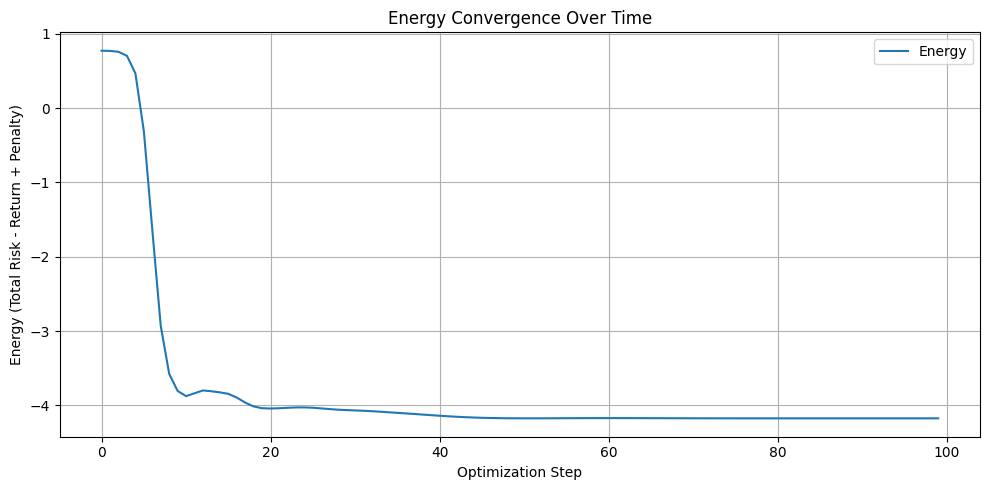

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history, label="Energy")
plt.xlabel("Optimization Step")
plt.ylabel("Energy (Total Risk - Return + Penalty)")
plt.title("Energy Convergence Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# Change device to finite shots for measurement
dev_meas = qml.device("default.qubit", wires=n_assets, shots=1000)

@qml.qnode(dev_meas)
def measure_final_state(params):
    qml.templates.StronglyEntanglingLayers(params, wires=range(n_assets))
    return [qml.sample(qml.PauliZ(i)) for i in range(n_assets)]

samples = np.array(measure_final_state(final_params)).T  # shape: (shots, n_assets)

# Convert Z-basis measurement (-1, +1) → binary decisions (0, 1)
binary_samples = ((1 - samples) // 2).astype(int)

# Count how many times each property was selected
selection_prob = np.mean(binary_samples, axis=0)
selected = np.where(selection_prob >= 0.5)[0]

print("Final Selected Properties:", selected)
print("Selection Probabilities:", selection_prob)

Final Selected Properties: [0 2]
Selection Probabilities: [0.999 0.001 1.    0.   ]


In [6]:
print("Final Optimized Parameters (StronglyEntanglingLayers):")
print(final_params)

Final Optimized Parameters (StronglyEntanglingLayers):
[[[ 2.42299200e-03 -4.00292074e-05  1.44419242e-02]
  [-8.03643115e-03  6.25858728e+00  1.63811650e-02]
  [-4.59403912e-03 -4.22730406e-13 -2.67011084e-03]
  [ 9.85343080e-03 -7.64484272e-12  3.84941202e-03]]

 [[-1.44677430e-02 -2.95191630e-04 -1.44624940e-02]
  [-1.51004320e-02  4.13648385e-12 -1.70617422e-02]
  [-3.06440884e-03 -3.14159265e+00 -1.23315930e-02]
  [ 8.53327716e-03  1.37048138e-15  8.23824561e-03]]]


In [7]:
def binary_to_z(x):
    return 1 - 2 * np.array(x)  # x in {0,1} → z in {-1,+1}

def portfolio_energy(x_binary):
    z = binary_to_z(x_binary)
    total = sum(h[i] * z[i] for i in range(n_assets))
    total += sum(J[i][j] * z[i] * z[j] for i in range(n_assets) for j in range(i+1, n_assets))
    return total + const

# Random valid portfolio (sum = B)
np.random.seed(42)
random_x = np.zeros(n_assets, dtype=int)
random_x[np.random.choice(n_assets, B, replace=False)] = 1

baseline_energy = portfolio_energy(random_x)
print("Random Baseline Portfolio Energy:", baseline_energy)

improvement = 100 * (baseline_energy - final_energy) / abs(baseline_energy)
print(f"Optimization Improvement over Random: {improvement:.2f}%")

Random Baseline Portfolio Energy: -3.6249999999999996
Optimization Improvement over Random: 15.17%


In [8]:
import cvxpy as cp
import numpy as np

# x_i ∈ {0, 1}
x = cp.Variable(n_assets, boolean=True)

# QUBO components
risk_term = cp.quad_form(x, q * sigma)
return_term = mu @ x
budget_penalty = lam * cp.square(cp.sum(x) - B)

# Objective function
objective = cp.Minimize(risk_term - return_term + budget_penalty)
problem = cp.Problem(objective)
problem.solve(solver=cp.ECOS_BB)

# Extract classical solution
x_classical = np.round(x.value).astype(int)

# Convert to z-basis for energy comparison
def binary_to_z(x_bin):
    return 1 - 2 * np.array(x_bin)

def portfolio_energy(x_bin):
    z = binary_to_z(x_bin)
    total = sum(h[i] * z[i] for i in range(n_assets))
    total += sum(J[i][j] * z[i] * z[j] for i in range(n_assets) for j in range(i + 1, n_assets))
    return total + const

classical_energy = portfolio_energy(x_classical)

# Compare with random and quantum
random_improvement = 100 * (baseline_energy - classical_energy) / abs(baseline_energy)
quantum_improvement = 100 * (classical_energy - final_energy) / abs(classical_energy)

print("Classical Portfolio:", x_classical)
print("Classical Energy:", classical_energy)
print(f"Improvement over Random: {random_improvement:.2f}%")
print(f"Improvement of Quantum over Classical: {quantum_improvement:.2f}%")

Classical Portfolio: [0 1 0 1]
Classical Energy: -3.6249999999999996
Improvement over Random: 0.00%
Improvement of Quantum over Classical: 15.17%
